<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_processing_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pystac_client
!pip install rasterio
# !pip install rio_cogeo
from pystac_client import Client as stac_client
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import dask
from dask.distributed import Client
import xarray as xr
import numpy as np

from skimage.filters import threshold_otsu
from scipy import ndimage as ndi

import rasterio
from rasterio.windows import from_bounds
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import geometry_mask, rasterize
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
from rasterio.vrt import WarpedVRT


from cv2 import dilate
from shapely import bounds
from shapely.geometry import box, mapping
from shapely.ops import transform as shp_transform
from pyproj import Transformer

# from rio_cogeo import cogeo
from google.colab import drive
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime

import glob
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

  Using cached pystac_client-0.9.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached pystac-1.14.1-py3-none-any.whl.metadata (4.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 5.2 MB/s eta 0:00:00


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


Functions

In [5]:
def intersects(item_bbox, poly):
    return shapely.box(*item_bbox).intersects(poly)


def scale_to_reflectance(dn):
    return dn.astype('float32') * 1e-4


def scale_to_8bit(dn):
    return (((dn + 1) / 2) * 255).astype('int8')


def normalized_difference(x, y):
    denominator = x + y
    normalized_diff = (x - y) / np.where(denominator != 0, denominator, np.nan)

    return normalized_diff

In [6]:
gage = True

Import vector assets

In [7]:

if not gage:
    squares = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/all_sites/squares_15x_20250903.shp')\
        .set_index('iindex', drop=False)\
        .to_crs('EPSG:4326')

    pills = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/all_sites/pills_3L_3W_20250903.shp')\
        .set_index('iindex', drop=False)\
        .to_crs('EPSG:4326')


    circles = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/all_sites/buffs_3x_width_20250903.shp')\
        .set_index('iindex', drop=False)\
        .to_crs('EPSG:4326')



else:
    squares = gpd.read_file('/content/drive/MyDrive/gage_squares_15x_20250918.shp')\
        .set_index('iindex', drop=False)
    pills = gpd.read_file('/content/drive/MyDrive/gage_pills_3L_3W_20250918.shp')\
        .set_index('iindex', drop=False)
    circles = gpd.read_file('/content/drive/MyDrive/gage_circles_3x_20250918.shp')\
        .set_index('iindex', drop=False)
    pts = gpd.read_file('/content/drive/MyDrive/gage_points_20250918.shp')\
        .set_index('iindex', drop=False)



vector_centerline = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp')


In [ ]:
squares.total_bounds.tolist()

Generate list of images for specified date range over study area

Pair images with buffer iindices

Write to csv for easy future access without redoing stac search

In [ ]:

stac = stac_client.open('https://earth-search.aws.element84.com/v1')
if not gage:
    search = stac.search(
        collections=['sentinel-2-l2a'],
        bbox = squares.total_bounds.tolist(),
        datetime='2018-01-01/2024-12-31',
        query={'eo:cloud_cover': {'lt':20}},
        fields={'include': ['id', 'assets.B03', 'assets.B08', 'assets.SCL', 'bbox', 'properties.datetime']}
    )

    items = list(search.items())


    work = []
    for item in tqdm(items):
        ibox = item.bbox
        for idx, row in squares.iterrows():
            if intersects(ibox, row.geometry):
                work.append((item, idx))


    files_w_ids = pd.DataFrame(work)

    files_w_ids.to_csv('/content/drive/MyDrive/stac_ids_iidx_clouds_lt20.csv')

else:

    gage_search = stac.search(
        collections=['sentinel-2-l2a'],
        bbox=squares.total_bounds.tolist(),
        datetime='2018-01-01/2024-12-31',
        query={'eo:cloud_cover': {'lt': 20}},
        fields={'include': ['id', 'assets.B03', 'assets.B08', 'assets.SCL', 'bbox', 'properties.datetime']}
    )
    items = list(gage_search.items())

    work = []
    for item in items:
        ibox = item.bbox
        for idx, row in pts.iterrows():
            if intersects(ibox, row.geometry):
                work.append((item, idx))

    files_w_ids = pd.DataFrame(work)
    files_w_ids.to_csv('/content/drive/MyDrive/gage_stac_ids_iidx_clouds_lt20_20250918.csv')

In [ ]:
(tile_dt_version_df)

In [ ]:
work = pd.read_csv('/content/drive/MyDrive/stac_ids_iidx_clouds_lt20_20250918.csv')
work.columns = ['del', 'img_id', 'iindex']
work = work[['img_id', 'iindex']]

work['img_id'] = work.apply(lambda x: x['img_id'].split('=')[1][:24], axis=1)
work['mgrs'] = work.apply(lambda x: x['img_id'].split('_')[1], axis=1)
work['date'] = work.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
work['version'] = work.apply(lambda x: x['img_id'].split('_')[3], axis=1)

tile_dts = []
tile_dt_versions = []
for row in tqdm(work.iterrows()):
    tile = row[1]['mgrs']
    dt = row[1]['date']
    version = row[1]['version']
    tile_dts.append((tile, dt))
    tile_dt_versions.append((tile, dt, version))


tile_dt_version_df = pd.DataFrame(set(tile_dt_versions), columns=['mgrs', 'date', 'version'])\
    .sort_values('date')
nonduplicates = []

for combo in tqdm(set(tile_dts)):
    temp_mgrs = combo[0]
    temp_dt = combo[1]
    temp_df = tile_dt_version_df.loc[(tile_dt_version_df.mgrs == temp_mgrs) & (tile_dt_version_df.date == temp_dt)]\
        .sort_values('version', ascending=False)\
        .reset_index()

    df_out = temp_df.head(1)
    nonduplicates.append(df_out)

nonduplicates = pd.concat(nonduplicates)

In [ ]:
nonduplicate_work = pd.merge(work, nonduplicates[['mgrs', 'date', 'version']], 'right', on=['mgrs', 'date', 'version'])
# nonduplicate_work.to_csv('/content/drive/MyDrive/nonduplicate_stac_ids.csv')

In [ ]:
pd.read_csv('/content/drive/MyDrive/nonduplicate_stac_ids_20250918.csv')

Read image ids and buffer ids from csv

In [8]:
if gage:
    work = pd.read_csv('/content/drive/MyDrive/nonduplicate_stac_ids_20250918.csv')
    work['date'] = pd.to_datetime(work['date'])
    work['year'] = work.apply(lambda x: x['date'].year, axis=1)
    work['month'] = work.apply(lambda x: x['date'].month, axis=1)
else:
    work = pd.read_csv('/content/drive/MyDrive/nonduplicate_stac_ids.csv')
work

,Unnamed: 0,img_id,iindex,mgrs,date,version,year,month
0,0,S2A_13TCF_20180427_0_L2A,41900,13TCF,2018-04-27,0,2018,4
1,1,S2B_14TMM_20180423_0_L2A,79518,14TMM,2018-04-23,0,2018,4
2,2,S2B_14TMM_20180423_0_L2A,68202,14TMM,2018-04-23,0,2018,4
3,3,S2A_14TQM_20220626_0_L2A,120725,14TQM,2022-06-26,0,2022,6
4,4,S2A_14TPM_20210906_0_L2A,120725,14TPM,2021-09-06,0,2021,9
...,...,...,...,...,...,...,...,...
13434,13434,S2B_14TML_20200721_1_L2A,217337,14TML,2020-07-21,1,2020,7
13435,13435,S2B_14TML_20200721_1_L2A,210361,14TML,2020-07-21,1,2020,7
13436,13436,S2A_15TTG_20210112_1_L2A,120725,15TTG,2021-01-12,1,2021,1
13437,13437,S2A_14TPM_20191209_1_L2A,120725,14TPM,2019-12-09,1,2019,12


In [9]:
stac = stac_client.open('https://earth-search.aws.element84.com/v1')
def search_stac_by_id(id):
    search = stac.search(collections=['sentinel-2-l2a'],
                         ids=[id],
                         fields={'include': ['id', 'assets.B03', 'assets.B08', 'assets.SCL', 'bbox', 'properties.datetime']})

    # items = list(search.items())
    return list(search.items())[0]

In [37]:

def ref_geoms(img, poly_idx, view_geoms, otsu_geoms, effwidth_geoms, centerline_geoms):
    b3_href = img.assets["green"].href
    with rasterio.open(b3_href) as src:
        img_crs = src.crs

    view_geom  = view_geoms.loc[poly_idx].geometry
    otsu_geom  = otsu_geoms.loc[poly_idx].geometry
    eff_geom   = effwidth_geoms.loc[poly_idx].geometry

    t_view  = Transformer.from_crs(view_geoms.crs, img_crs,  always_xy=True).transform
    t_otsu  = Transformer.from_crs(otsu_geoms.crs, img_crs,  always_xy=True).transform
    t_eff   = Transformer.from_crs(effwidth_geoms.crs, img_crs, always_xy=True).transform

    view_src = shp_transform(t_view, view_geom)
    otsu_src = shp_transform(t_otsu, otsu_geom)
    eff_src  = shp_transform(t_eff,  eff_geom)

    # Filter lines by intersection in image CRS, then reproject only those (cheap)
    if centerline_geoms.crs != img_crs:
        cl_img = centerline_geoms.to_crs(img_crs)
    else:
        cl_img = centerline_geoms
    hits = list(cl_img.sindex.query(otsu_src, predicate="intersects"))
    lines_in_bound = cl_img.iloc[hits].copy()

    return view_src, otsu_src, eff_src, lines_in_bound

def dn_to_reflectance(band):
    return np.float32(band) * 1e-4


def normalized_difference(b1, b2):
    denominator = b1 + b2
    numerator = b1 - b2
    return numerator / np.where(denominator != 0, denominator, np.nan)



def process_image(img, view_geom, otsu_geom):
    b3_href = img.assets['green'].href
    b8_href = img.assets['nir'].href
    scl_href = img.assets['scl'].href


    l, b, r, t = view_geom.bounds

    with rasterio.open(b3_href) as b3_src:
        wwindow = rasterio.windows.from_bounds(l, b, r, t, b3_src.transform).round_offsets().round_lengths()

        wwindow_transform = b3_src.window_transform(wwindow)

        b3v = b3_src.read(1, window=wwindow, masked=True)
        h, w = wwindow.height, wwindow.width
        b3_crs = b3_src.crs

    with rasterio.open(b8_href) as b8_src:
        b8v = b8_src.read(1, window=wwindow, masked=True)

    with rasterio.open(scl_href) as scl_src, WarpedVRT(
            scl_src,
            crs=b3_crs,
            transform=wwindow_transform, width=w, height=h,
            resampling=Resampling.nearest
         ) as vrt:
        sclv = vrt.read(1)
                        # , window=rasterio.windows.from_bounds(l, b, r, t, transform=scl_src.transform).round_offsets().round_lengths(), out_shape=(1, h, w), resampling=Resampling.nearest)

    sclv = np.ma.MaskedArray(sclv, mask=np.zeros_like(sclv, dtype=bool))
    b3v = dn_to_reflectance(b3v)
    b8v = dn_to_reflectance(b8v)

    ndwi_v = normalized_difference(b3v, b8v)
    # print(ndwi_v.min())
    # print(ndwi_v.max())

    otsu_geom_mask = geometry_mask([otsu_geom], out_shape=(h, w), transform=wwindow_transform, invert=True)
    if otsu_geom_mask.size <= ndwi_v.size:
        ndwi_o = np.ma.array(ndwi_v, mask=~otsu_geom_mask).compressed()
        b8o = np.ma.array(b8v, mask=~otsu_geom_mask).compressed()

        if ndwi_o.size >= 10:
            ndwi_threshold = threshold_otsu(ndwi_o)
            nir_threshold = threshold_otsu(b8o)
        else:
            ndwi_threshold = 1
            nir_threshold = 1

        wmask = (ndwi_v >= ndwi_threshold) & (b8v <= nir_threshold)

        cloudmask = np.isin(sclv, [7, 8, 9]).astype('uint8')
        snowmask = (sclv == 11).astype('uint8')
        ndmask = (sclv != 0).astype('uint8')

        return ndwi_v, wmask, cloudmask, snowmask, ndmask, wwindow_transform
    else:
        return np.array([1]), None, None, None, None, None


def identify_river(wmask, lines, window_trans):
    # vcl_reproj = vector_centerlines.to_crs(img_crs)
    # line_nos_in_bounds = list(vcl_reproj.sindex.query(otsu_geom, predicate='intersects'))
    # lines_in_bound = vcl_reproj.iloc[line_nos_in_bounds]
    h, w = wmask.shape
    wbool = wmask.filled(0) > 0
    rbuffs = lines.copy().buffer(5)
    shapes = ((geom, 1) for geom in rbuffs)
    river_seed = rasterize(
        shapes=shapes,
        out_shape= (h, w),
        transform=window_trans,
        fill=0,
        dtype='uint8',
        all_touched=True
    )
    structure = np.ones((3, 3), dtype=bool)
    river_mask = ndi.binary_propagation(input=river_seed * wbool, mask=wbool, structure=structure)
    return river_mask


def GENERATE_MASKS(img_id, poly_idx, squares, pills, circles, vector_centerlines):
    image = search_stac_by_id(img_id)

    square, pill, circle_geom, lines = ref_geoms(image, poly_idx, squares, pills, circles, vector_centerlines)

    ndwi_v, wmask, cloudmask, snowmask, ndmask, wwindow_transform = process_image(image, square, pill)
    if ndwi_v.size > 1:

        rmask = identify_river(wmask, lines, wwindow_transform)

        return ndwi_v, rmask, cloudmask, snowmask, ndmask, wwindow_transform, circle_geom
    else:
        return np.array([1]), None, None, None, None, None, None


def count_pixels(rmask, cloudmask, snowmask, ndmask, transform, circle):
    circle_mask = rasterize([circle], out_shape = rmask.shape, transform=transform, dtype='uint8', all_touched=True) == 1

    kernel = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]]).astype('uint8')
    big_circle = dilate(circle_mask.astype('uint8'), kernel, iterations=1)
    ring_mask = big_circle & ~circle_mask

    n_pixels = circle_mask.sum()
    n_valid = (circle_mask & ndmask).sum()
    n_river = (circle_mask & rmask).sum()
    n_cloud = (circle_mask & cloudmask).sum()
    n_snow = (circle_mask & snowmask).sum()
    n_cloudriver = (circle_mask & rmask & cloudmask).sum()

    n_edge = ring_mask.sum()
    n_edgeriver = (ring_mask & rmask).sum()

    return n_pixels, n_valid, n_river, n_cloud, n_snow, n_cloudriver, n_edge, n_edgeriver

In [48]:
def show_plot(img_id, poly_idx, squares, pills, circles, vector_centerlines):
    ndwi, rmask, cloudmask, snowmask, ndmask, wwindow_transform, circle_poly = GENERATE_MASKS(img_id, poly_idx, squares, pills, circles, vector_centerlines)

    rm_cdict = {
            'red':   [[0.0, 0.0, 0.0],
                      [1.0, 1.0, 1.0]],
            'green': [[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0]],
            'blue':  [[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0]],
            'alpha': [[0.0, 0.0, 0.0],
                      [1.0, 0.35, 1.0]]
        }
    rm_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=rm_cdict)

    cm_cdict = {
        'red':      [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'green':    [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'blue':     [[0.0, 0.0, 0.0],
                     [1.0, 1.0, 0.0]],
        'alpha':    [[0.0, 0.0, 0.0],
                     [1.0, 0.2, 1.0]]
    }
    cm_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=cm_cdict)

    fig, ax = plt.subplots()
    show(ndwi, cmap='Greys_r', ax=ax, transform=wwindow_transform)
    show(rmask, cmap=rm_cmap, ax=ax, transform=wwindow_transform)
    show(cloudmask, cmap=cm_cmap, ax=ax, transform=wwindow_transform)
    gpd.GeoSeries([circle_poly]).plot(ax=ax, facecolor='none')

    # tfig = plt.Figure()
    # ax_ndwi = tfig.add_subplot(1, 2, 1)
    # show(ndwi, cmap='Greys_r', ax=ax_ndwi)
    # ax_scl = tfig.add_subplot(1, 2, 2)
    # show(ndmask, cmap='Paired', ax=ax_scl)
    # tfig.suptitle(f'{img_id}_{poly_idx}')
    # tfig.tight_layout()

    # return fig

Get effective width at all gage sites in for loop\
Will identify good images after the fact using river tinder

In [ ]:
def _worker(args):
    img_id_str, idx = args
    img_id = img_id_str
    # .split('=')[1][:24]

    ndwi, rmask, cloudmask, snowmask, ndmask, trans, circle_poly = GENERATE_MASKS(
        img_id, idx, squares, pills, circles, vector_centerline
    )

    if ndwi.size > 1:
        return(img_id_str, idx, *count_pixels(rmask, cloudmask, snowmask, ndmask, trans, circle_poly))
        # return(img_id_str, idx, n_pixels, n_valid, n_river, n_cloud, n_snow, n_cloud)
    else:
        return(img_id_str, idx, -999, -999, -999, -999, -999, -999, -999, -999)


if gage:
    # work['date'] = pd.to_datetime(work['date'])
    # work['year'] = work.apply(lambda x: (x['date']).year, axis=1)
    # work['month'] = work.apply(lambda x: (x['date']).month, axis=1)

    for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
        # for month in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        path_out = (f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{year}_g2_20250920.csv')
        if path_out not in glob.glob(os.path.join('/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_*.csv')):

            tempwork = work.loc[(work.year == year)].copy()
            records = list(zip(tempwork['img_id'].tolist(), tempwork['iindex'].astype(int).tolist()))

            results = []

            with ProcessPoolExecutor(max_workers=min(8, mp.cpu_count())) as ex:
                futures = [ex.submit(_worker, r) for r in records]
                for f in tqdm(as_completed(futures), total=len(futures), desc=f'{year}'):
                    results.append(f.result())

            output = pd.DataFrame(results, columns=['img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river', 'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver'])
            output.to_csv(path_out)

else:

    work['date'] = pd.to_datetime(work['date'])
    work['year'] = work.apply(lambda x: (x['date']).year, axis=1)
    work['month'] = work.apply(lambda x: (x['date']).month, axis=1)

    completed_my = [(1, 2018)]
    for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
        for month in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
            path_out = f'/content/drive/MyDrive/effwidth_results/all_sites/effwidths_{month}_{year}.csv'

            if path_out not in glob.glob(os.path.join('/content/drive/MyDrive/effwidth_results/all_sites/effwidths_*.csv')):

                tempwork = work.loc[(work.year == year) & (work.month == month)].copy()

                records = list(zip(tempwork['img_id'].tolist(), tempwork['iindex'].astype(int).tolist()))

                results = []

                with ProcessPoolExecutor(max_workers=min(8, mp.cpu_count())) as ex:
                    futures = [ex.submit(_worker, r) for r in records]
                    for f in tqdm(as_completed(futures), total=len(futures), desc=f'{year}-{month}'):
                        results.append(f.result())
                # for record in tqdm(records):
                #     results.append(_worker(record))
                output = pd.DataFrame(results, columns=['img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river', 'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver'])
                output.to_csv(path_out)

                completed_my.append((month, year))

2018:   2%|▏         | 34/1761 [01:26<1:25:27,  2.97s/it]

In [ ]:
for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    for month in range(1, 13):
        tempwork = work.loc[(work.year == year) & (work.month == month)]
        comp = pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{month}_{year}_g2.csv')
        print(year, "-", month, ": ", len(tempwork) == len(comp))

In [39]:
output

,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver
0,S2A_14TQM_20180108_0_L2A,120725,164,164,12,57,103,1,43,2
1,S2A_13SDD_20180107_0_L2A,38194,71,71,2,51,0,2,29,3
2,S2A_13SDD_20180107_0_L2A,38526,41,41,15,8,0,3,22,4
3,S2B_13TGF_20180109_0_L2A,225467,162,162,80,0,162,0,43,18
4,S2A_13TEE_20180114_0_L2A,41178,254,254,27,73,0,3,54,3
5,S2A_13TEE_20180114_0_L2A,35136,40,40,5,10,0,1,23,0
6,S2A_13TEE_20180114_0_L2A,30618,544,544,95,100,0,40,77,4
7,S2B_13SDD_20180109_0_L2A,38194,71,71,24,71,0,24,29,3
8,S2B_13SDD_20180109_0_L2A,38526,41,41,6,41,0,6,22,4
9,S2A_13TDE_20180104_0_L2A,41178,254,254,34,66,0,9,54,1


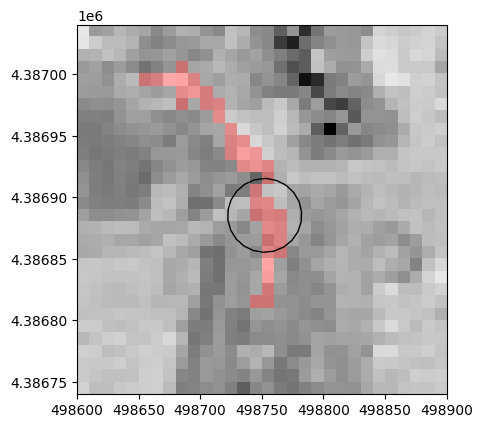

In [49]:
n = 18
# ndwi, rmask, cloudmask, snowmask, ndmask, trans, circle_geom = GENERATE_MASKS('S2A_13SDD_20180107_0_L2A', 38194, squares, pills, circles, vector_centerline)

show_plot(output.loc[n, 'img_id'], output.loc[n, 'iindex'], squares, pills, circles, vector_centerline)